# Spectral calustering

### Important libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from DataMatrix import generate_data_matrix
from sklearn.neighbors import kneighbors_graph
import warnings
warnings.filterwarnings("ignore")

## Spectral clustering implementation

- similarity matrix

In [2]:
def similarity_matrix(X, sigma=0.1):
    pairwise_sq_dists = np.square(pairwise_distances(X, metric='euclidean'))
    return np.exp(-pairwise_sq_dists / (2. * sigma ** 2))

In [3]:
def knn_similarity_matrix(X, n_neighbors=10):
    return kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=True).toarray()

In [4]:
def consine_similarity_matrix(X):
    X = normalize(X)
    return X.dot(X.T)

- laplacian-a matrix

In [5]:
def laplacian_a_matrix(W):
    D = np.diag(np.sum(W, axis=1))
    D_inv = np.linalg.inv(D)
    I = np.eye(len(D))
    return I - np.dot(D_inv, W)


In [6]:
def normalized_laplacian(W):
    D = np.diag(np.sum(W, axis=1))
    D_sqrt_inv = np.diag(1.0 / np.sqrt(np.sum(W, axis=1)))
    return np.dot(D_sqrt_inv, np.dot(D - W, D_sqrt_inv))

- spectral clustering

In [7]:
def spectral_clustering(X, n_clusters=19,sim='ecu' ,laplacian='a',n_neighbours=10,sigma=0.1):
    if sim == "ecu":
        W = similarity_matrix(X, sigma)
    elif sim == "cos":
        W = consine_similarity_matrix(X)
    else:
        W = knn_similarity_matrix(X,n_neighbors=n_neighbours)
    if laplacian == 'a':
        L = laplacian_a_matrix(W)
    else:
        L = normalized_laplacian(W)
    eigenvalues, eigenvectors = np.linalg.eig(L)
    idx = eigenvalues.argsort()  
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors = np.real(eigenvectors)
    norm_eigenvectors = normalize(eigenvectors[:, :n_clusters], norm='l2', axis=1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(norm_eigenvectors)
    return kmeans

### load the data in the first solution method `Mean Method`

In [8]:
x_train,y_train,x_test,y_test = generate_data_matrix(method="mean")
print("X_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (7296, 45)
y_train shape:  (7296, 1)
X_test shape:  (1824, 45)
y_test shape:  (1824, 1)


In [72]:
model1 = spectral_clustering(x_test, n_clusters=19,sim="knn",laplacian='a',n_neighbours=75)

In [73]:
labels1=model1.labels_

### load the data in the second solution method `Flatten Method`

In [31]:
x_f_train, y_f_train, x_f_test, y_f_test= generate_data_matrix(method="flatten")
print("X_train shape: ", x_f_train.shape)
print("y_train shape: ", y_f_train.shape)
print("X_test shape: ", x_f_test.shape)
print("y_test shape: ", y_f_test.shape)

X_train shape:  (7296, 870)
y_train shape:  (7296, 1)
X_test shape:  (1824, 870)
y_test shape:  (1824, 1)


In [75]:
model2 = spectral_clustering(x_f_test, n_clusters=19,sim="knn",laplacian='a',n_neighbours=100)

In [79]:
labels2=model2.labels_

array([18, 18, 18, ..., 10,  5,  1], dtype=int32)

## Measurement method 

In [64]:
def construct_clusters(true_labels,labels):
    clusters = {}
    for i in range(len(true_labels)):
        if labels[i] in clusters:
            clusters[labels[i]].append(true_labels[i])
        else:
            clusters[labels[i]]=[true_labels[i]]        
    return clusters

### Entropy method

In [15]:
def conditional_entropy(clusters,n_samples):
    H = 0
    for cluster in clusters.values():
        n = len(cluster)
        s=-sum([(cluster.count(label)/n) * np.log2(cluster.count(label)/n) for label in set(cluster)])
        H += (n/n_samples) * s
    return H

### Precision & Recall method

In [16]:
def precision_recall(clusters):
    precision = 0
    recall = 0
    for cluster in clusters.values():
        mx=0
        val=0
        for i in set(cluster):
            x=cluster.count(i)
            if x > mx:
                mx = x
                val = i
        p = mx/len(cluster)
        num_val=mx
        for cluster2 in clusters.values():
            if cluster != cluster2:
                num_val+=cluster2.count(val)
        r = mx/num_val
        precision += p
        recall += r
        
    return precision/len(clusters),recall/len(clusters)

### F1 score method

In [17]:
def f_measure( clusters):
    f = 0
    num_clusters = len(clusters)
    for cluster in clusters.values():
        mx=0
        val=0
        for i in set(cluster):
            x=cluster.count(i)
            if x > mx:
                mx = x
                val = i
        p = mx/len(cluster)
        num_val=mx
        for cluster2 in clusters.values():
            if cluster != cluster2:
                num_val+=cluster2.count(val)
        r = mx/num_val
        f += (2*p*r)/(p+r)
    return f/num_clusters

In [ ]:
def get_metrics(true_labels,labels):
    clusters=construct_clusters(true_labels,labels)
    n_samples = len(true_labels)
    H = conditional_entropy(clusters,n_samples)
    precision,recall = precision_recall(clusters)
    f = f_measure(clusters)
    return H,precision,recall,f

## Comparison of the first and second methods

Method 1
Conditional Entropy:  1.2212962277954815
Precision:  0.6623967725461605
Recall:  0.6452850877192983
F-measure:  0.635062575359446
Method 2
Conditional Entropy:  1.2874077738157095
Precision:  0.6595693858100173
Recall:  0.6277412280701755
F-measure:  0.6203440895890981
Difference in Conditional Entropy:  -0.06611154602022795
Difference in Precision:  0.0028273867361431337
Difference in Recall:  0.01754385964912275
Difference in F-measure:  0.014718485770347844


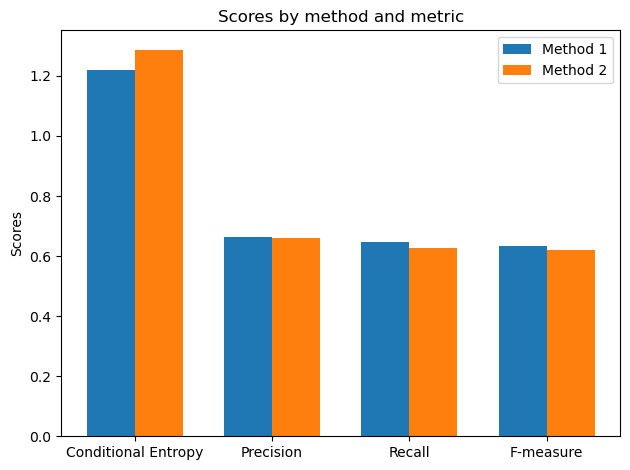

In [80]:
def compare_methods(true_labels,labels1,labels2):
    H1,precision1,recall1,f1 = get_metrics(true_labels,labels1)
    H2,precision2,recall2,f2 = get_metrics(true_labels,labels2)
    print("Method 1")
    print("Conditional Entropy: ",H1)
    print("Precision: ",precision1)
    print("Recall: ",recall1)
    print("F-measure: ",f1)
    print("Method 2")
    print("Conditional Entropy: ",H2)
    print("Precision: ",precision2)
    print("Recall: ",recall2)
    print("F-measure: ",f2)
    print("Difference in Conditional Entropy: ",H1-H2)
    print("Difference in Precision: ",precision1-precision2)
    print("Difference in Recall: ",recall1-recall2)
    print("Difference in F-measure: ",f1-f2)
    
    # bar chart with results
    labels = ['Conditional Entropy', 'Precision', 'Recall', 'F-measure']
    method1 = [H1, precision1, recall1, f1]
    method2 = [H2, precision2, recall2, f2]
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, method1, width, label='Method 1')
    rects2 = ax.bar(x + width/2, method2, width, label='Method 2')
    ax.set_ylabel('Scores')
    ax.set_title('Scores by method and metric')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    fig.tight_layout()
    plt.show()
    
compare_methods(y_test.flatten(),labels1,labels2)

## Comparisons between Spectral Clustering and Kmeans

## Hyperparameter tuning

In [68]:
def spectral_clustering_analysis(X_train, n_clusters=19):
    labels={}
    sim = ["ecu","cos", "knn"]
    laplacian = ["a", "l"]
    n_neighbours = [15,20,50,100,150]
    sigma = [0.01,0.1, 0.5, 1]
    for s in sim:
        for l in laplacian:
            if s == "knn":
                for n in n_neighbours:
                    kmean = spectral_clustering(X_train, n_clusters=n_clusters, sim=s, laplacian=l, n_neighbours=n)
                    print(s+"_"+l+"_"+str(n))
                    labels[s+"_"+l+"_"+str(n)] = kmean.labels_
            else:
                for sig in sigma:
                    kmean = spectral_clustering(X_train, n_clusters=n_clusters, sim=s, laplacian=l, sigma=sig)
                    print(s+"_"+l+"_"+str(sig))
                    labels[s+"_"+l+"_"+str(sig)] = kmean.labels_
                    
    return labels

In [69]:
def get_best_params(labels,y_test):
    metrics = {}
    best_key = ""
    for key in labels:
        H,precision,recall,f = get_metrics(y_test.flatten(),labels[key])
        metrics[key] = [H,precision,recall,f]
        if best_key == "":
            best_key = key
        elif H < metrics[best_key][0]:
            best_key = key
    print(best_key)
    print(metrics[best_key])
    return metrics

def plot_metrics(metrics):
    H = []
    precision = []
    recall = []
    f = []
    for key in metrics:
        H.append(metrics[key][0])
        precision.append(metrics[key][1])
        recall.append(metrics[key][2])
        f.append(metrics[key][3])

    plt.figure(figsize=(10, 5))
    plt.plot(H, label="Conditional Entropy")
    plt.plot(precision, label="Precision")
    plt.plot(recall, label="Recall")
    plt.plot(f, label="F-Measure")
    plt.legend()
    plt.show()
    


In [ ]:
labels_dic= spectral_clustering_analysis(x_test, n_clusters=19)
metrics = get_best_params(labels_dic,y_test)
plot_metrics(metrics)

knn_a_100
[1.2874077738157095, 0.6595693858100173, 0.6277412280701755, 0.6203440895890981]


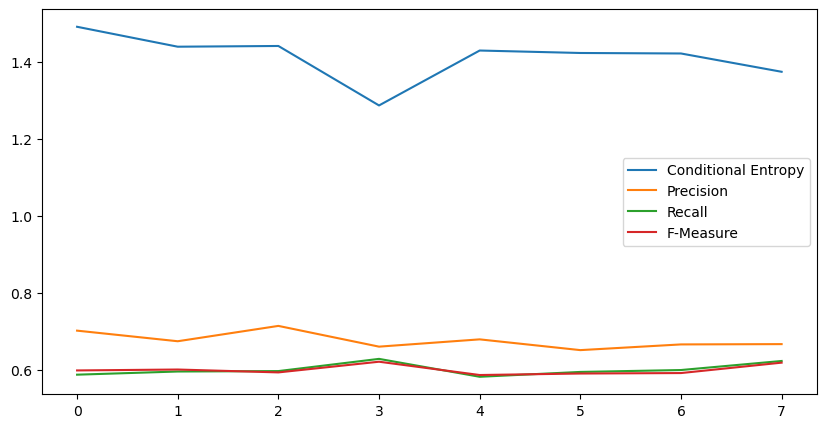

In [81]:
metrics = get_best_params(labels_dic,y_test)
plot_metrics(metrics)


In [ ]:
labels_dic= spectral_clustering_analysis(x_f_test, n_clusters=19)
metrics = get_best_params(labels_dic,y_f_test)
plot_metrics(metrics)

knn_a_100
[1.2874077738157095, 0.6595693858100173, 0.6277412280701755, 0.6203440895890981]


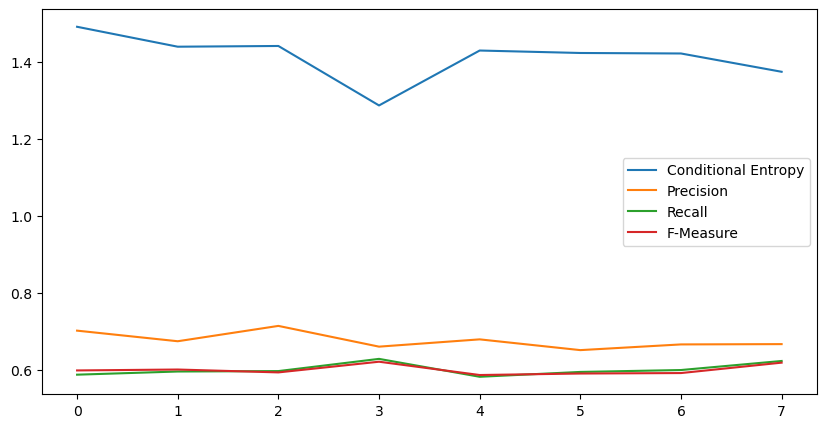

In [82]:
metrics = get_best_params(labels_dic,y_test)
plot_metrics(metrics)